# Check out how the channel might meander from the old radarlines to new

Interpolation of old and new radarline comes from 26_RADAR_interpolate_line2line_by_distance_downchan


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
new_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
old_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/1516_gprlines.shp')
old_gpr['camp'] = 'KIS2' 
bed_gdf = pd.concat([new_gpr,old_gpr])
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

In [3]:
x_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_x.npy')
y_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_y.npy')
it_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_ice_thickn.npy')

In [4]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')

In [5]:
x_oo = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_onlyold_points_x.npy')
y_oo = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_onlyold_points_y.npy')
it_oo = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_onlyold_ice_thickn.npy')

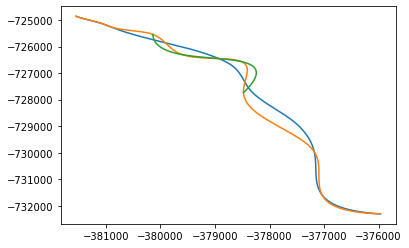

In [6]:
#old and new interpd lines
i=10
plt.plot(x_new[i,:],y_new[i,:],label='new')
plt.plot(x_old[i,:],y_old[i,:],label='old')
plt.plot(x_oo[i,:],y_oo[i,:],label='only old')

(-735000, -724000)

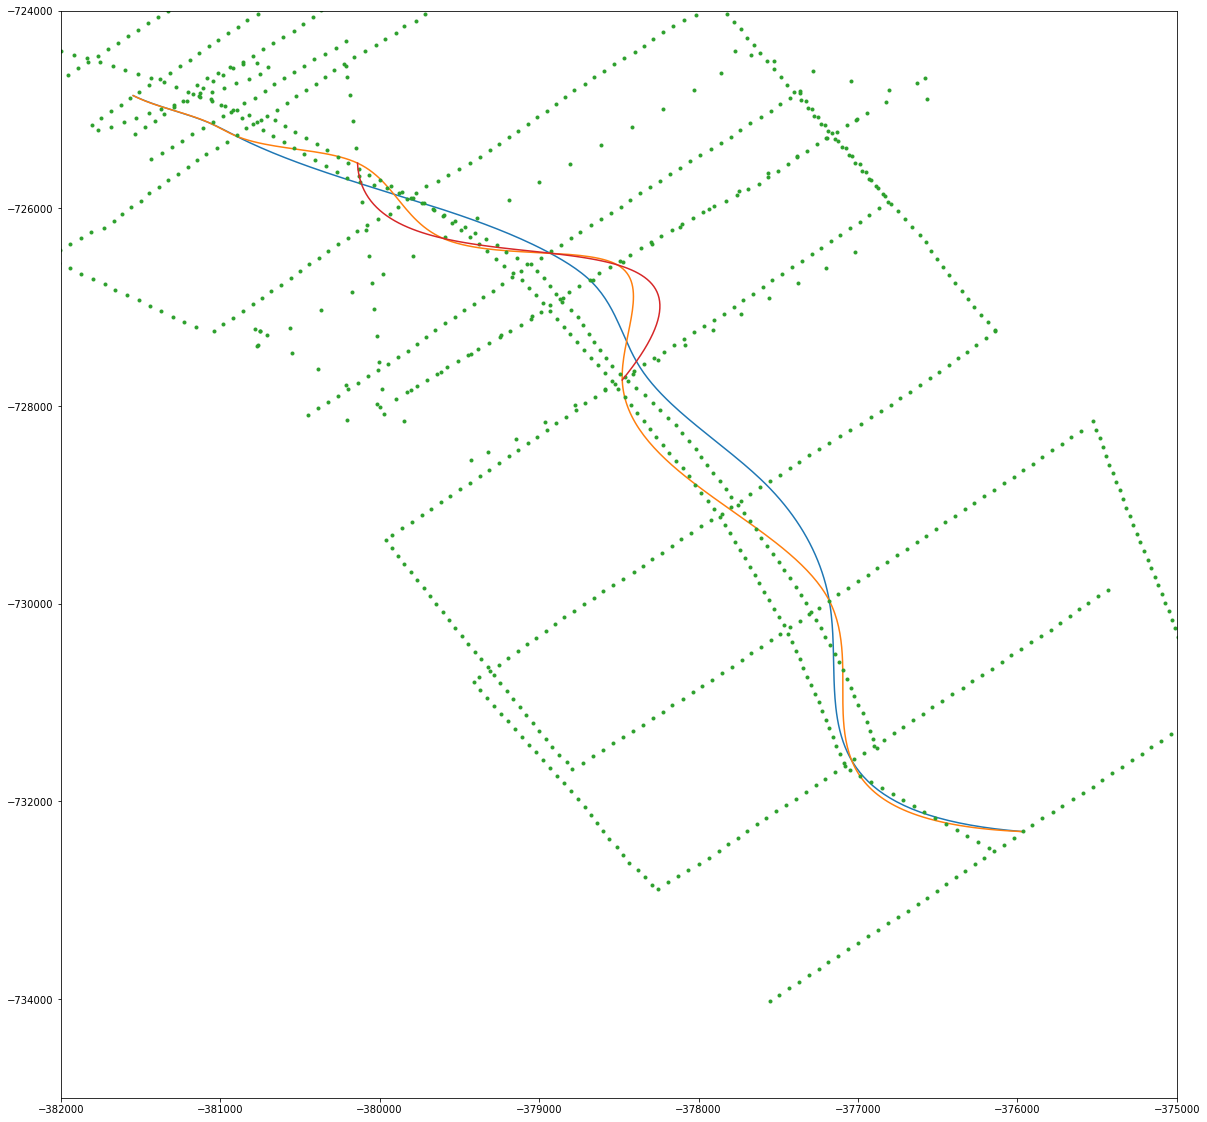

In [7]:

plt.figure(figsize=(20,20))
plt.plot(x_new[i,:],y_new[i,:],label='new')
plt.plot(x_old[i,:],y_old[i,:],label='old')
plt.plot(gdf.x[::30],gdf.y[::30],'.')
plt.plot(x_oo[i,:],y_oo[i,:],label='only old')
plt.xlim([-382000, -375000])
plt.ylim([-735000,-724000])

# in conclusion,

- it looks like a meander -
- i think its not best to use only old radar lines as it finishes on overly tight angle

In [8]:
points_x_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel.npy')
points_y_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel.npy') 
ice_thickn_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel.npy')
base_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_channel.npy')

In [9]:
points_x_surveyed_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel_old.npy')
points_y_surveyed_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel_old.npy') 
ice_thickn_surveyed_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel_old.npy')
base_surveyed_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_channel_old.npy')

(-735000, -724000)

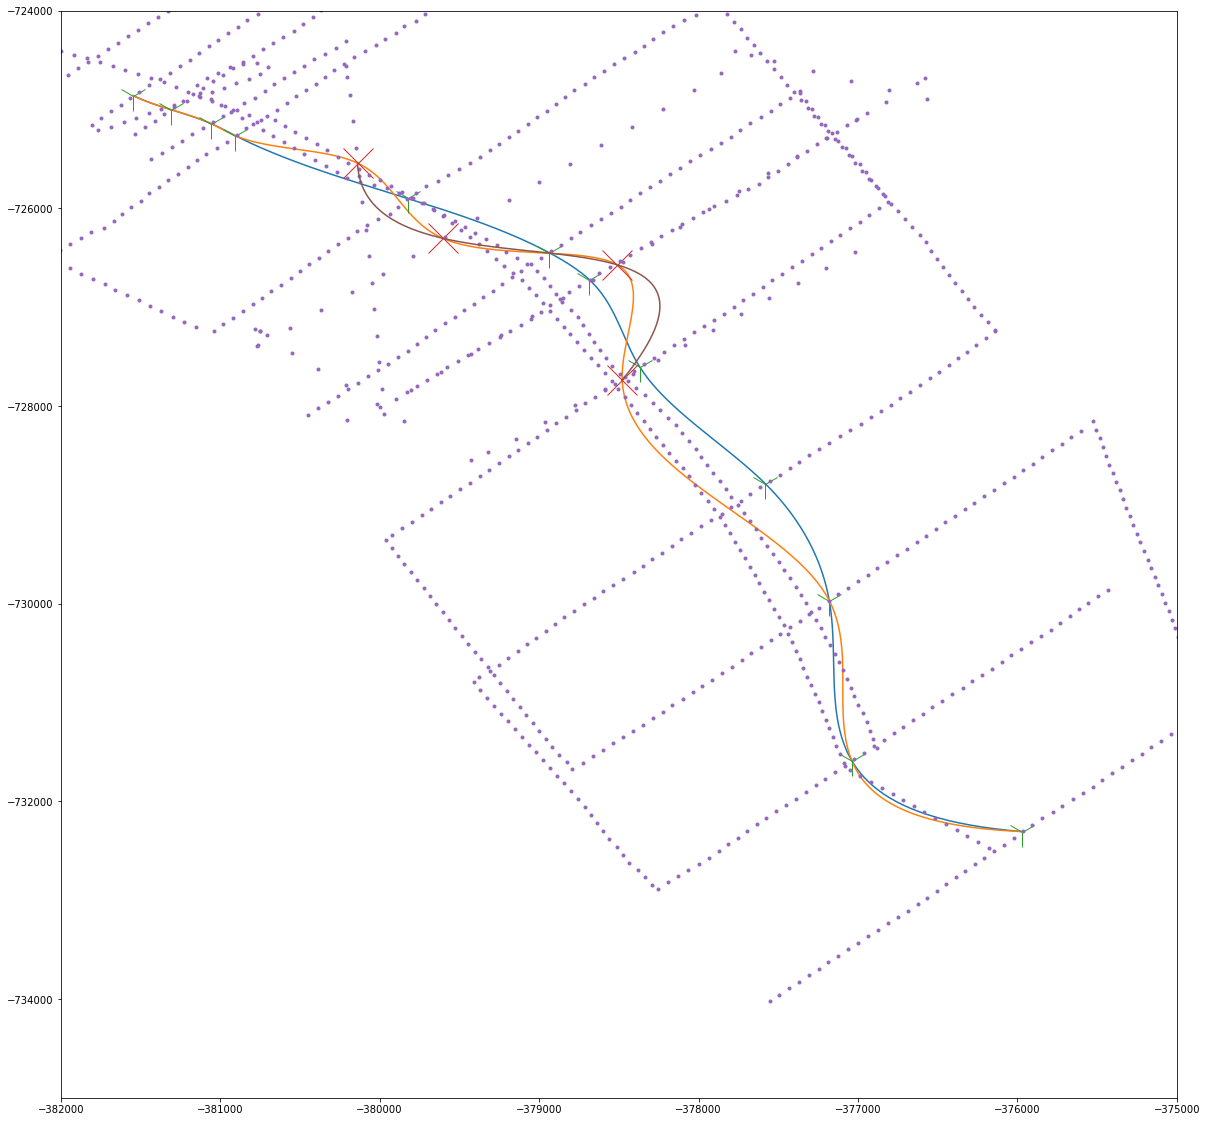

In [10]:
plt.figure(figsize=(20,20))
plt.plot(x_new[i,:],y_new[i,:],label='new')
plt.plot(x_old[i,:],y_old[i,:],label='old')
plt.plot(points_x_surveyed[10,:],points_y_surveyed[10,:],'1',markersize=30)
plt.plot(points_x_surveyed_old[10,:],points_y_surveyed_old[10,:],'x',markersize=30)
plt.plot(gdf.x[::30],gdf.y[::30],'.')
plt.plot(x_oo[i,:],y_oo[i,:],label='only old')
plt.xlim([-382000, -375000])
plt.ylim([-735000,-724000])

In [11]:
Points = pd.Series([Point(x,y) for x,y in zip(points_x_surveyed[10,:],points_y_surveyed[10,:])])

new_surveyed = gpd.GeoDataFrame(Points,geometry=Points,crs=3031)
Points_old = pd.Series([Point(x,y) for x,y in zip(points_x_surveyed_old[10,:],points_y_surveyed_old[10,:])])

old_surveyed = gpd.GeoDataFrame(Points_old,geometry=Points_old,crs=3031)

In [12]:
closest_point_index = []
closest_point_distance = []

for i,row in old_surveyed.iterrows():
    dist_to_all_points = [row.geometry.distance(newpoint) for newpoint in new_surveyed.geometry.tolist()]
    cpi = np.argmin(dist_to_all_points)
    closest_point_index.append( cpi )
    closest_point_distance.append( dist_to_all_points[cpi])

old_surveyed['closest_point_index'] = closest_point_index
old_surveyed['closest_point_distance'] = closest_point_distance

In [13]:
old_surveyed

,0,geometry,closest_point_index,closest_point_distance
0,POINT (-380139 -725542.9364351809),POINT (-380139.000 -725542.936),4,476.772993
1,POINT (-379604.4069034909 -726303.4069034909),POINT (-379604.407 -726303.407),4,458.690528
2,POINT (-378509.3734394268 -726572.3734394268),POINT (-378509.373 -726572.373),6,231.274519
3,POINT (-378478.5402908358 -727737.6716363112),POINT (-378478.540 -727737.672),7,170.368090


## Interpretation 

2 and 3 are the radarlines at the same points as new ones.
So we have 231 and 170m meander